In [1]:
import numpy as np 
import pandas as pd
from src import utils
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import rcParams
default_font = 12
fs_title = 16
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange', 'grey'] #rew #nrew #rew_test #nrew_test #GI

# Function library

In [62]:
def get_istim_matrix(m):
    """ 
    This function reshapes the interpolated spikes matrix to a 4D tensor with dimensions (nneurons, ncategories, nstimuli, positions)

    frameselector is a dataframe containing the all the relevant information of each frame so we can select the trials we want to analyze,
    in this case we are collapsing the trial types (rewarded, non rewarded, rewarded test, non rewarded test) into two categories (A and B) based on reward,
    then we loop per each category and stimulus to get the average response of each neuron to each stimulus given the available repeats.

    Parameters:
    m (object): a mouse data object

    Returns:
    id_responses (np.array): a 4D tensor with dimensions (nneurons, ncategories, nstimuli, positions)

    """

    colapsed = m.frameselector.assign(category = m.frameselector["trial_type"].map({"rewarded": "A", "non rewarded": "B", "rewarded test": "A", "non rewarded test": "B"}))
    category = ['A', 'B']
    nneurons = m.interp_spks.shape[0]
    id_responses = np.ones((nneurons, 2, 51, 400)) * np.nan
    for ic, cat in enumerate(category):
        for idx in np.arange(1,52):
            a = colapsed.query(f"istim=={idx} & category == '{cat}'")
            ix = idx - 1
            trials = a.trial_no.unique().astype(int) -1
            reps = len(a.trial_no.unique())
            if reps == 0:
                continue
            if reps >= 2:
                avg = m.interp_spks[:,trials,:].mean(1)
                id_responses[:, ic, ix,:] = avg
            else:
                resp = m.interp_spks[:,trials,:]
                id_responses[:, ic, ix,:] = resp.squeeze()
    print(id_responses.shape)
    return id_responses

def filter_neurons(m, area, category, celltype=None):
        """ 
        This function filters the neurons based on the area, category and celltype

        Parameters:
        m (object): a mouse data object
        area (str): the area of the brain to filter the neurons
        category (str): the category of the stimuli to filter the neurons
        celltype (str): the celltype to filter the neurons

        Returns:
        selection (np.array): a boolean array with the neurons that meet the criteria
        """

        try:
            ia = utils.get_region_idx(m.iarea, area)
        except:
            AssertionError("area must be 'V1', 'medial', 'lateral' or 'anterior'")
        if celltype is not None:
            if celltype == "Pyr":
                selected_type = np.logical_not(m.isred[:,0]).astype(bool)
            elif celltype == "Int":
                selected_type = m.isred[:,0].astype(bool)
            else:
                AssertionError("celltype must be 'Pyr' or 'Int' or None")
            if category == "A":
                dp = m.train_dp >= np.percentile(m.train_dp[ia*selected_type], 95)
            elif category == "B":
                dp = m.train_dp <= np.percentile(m.train_dp[ia*selected_type], 5)
            else:
                AssertionError("category must be A or B")
            selection = ia * dp * selected_type
            prop = selection.sum() / ia.sum()
        else:
            if category == "A":
                dp = m.train_dp >= np.percentile(m.train_dp[ia], 95)
            elif category == "B":
                dp = m.train_dp <= np.percentile(m.train_dp[ia], 5)
            else:
                AssertionError("category must be A or B")
            selection = ia * dp
            prop = selection.sum() / ia.sum()
        return selection, prop

def get_sim_matrix(m, id_responses, area, category, celltype=None):
    """ 
    This function calculates the similarity matrix between the average responses of the neurons to the stimuli of each category

    Parameters:
    m (object): a mouse data object
    id_responses (np.array): a 4D tensor with dimensions (nneurons, ncategories, nstimuli, positions)
    area (str): the area of the brain to filter the neurons
    category (str): the category of the stimuli to filter the neurons
    celltype (str): the celltype to filter the neurons

    Returns:
    representation_matrix (np.array): a 2D matrix with the similarity between the average responses of the neurons to the stimuli of each category
    """
    nneurons = id_responses.shape[0]
    id_resp_idx = id_responses.reshape(nneurons, 102, 400)
    from itertools import combinations
    representation_matrix = np.ones((102,102)) * np.nan
    pairs = list(combinations(np.arange(102),2))
    selection, _ = filter_neurons(m, area, category, celltype=celltype)
    id_area = id_resp_idx[selection,:,0:125].mean(2)
    for pair in pairs:
        instance_a = id_area[:,pair[0]]
        instance_b = id_area[:,pair[1]]
        corr = np.corrcoef(instance_a, instance_b)[0,1]
        representation_matrix[pair[0],pair[1]] = corr
        representation_matrix[pair[1],pair[0]] = corr
    return representation_matrix

def plot_sim_matrix(ax, representation_matrix):
    """ 
    handy function to plot the similarity matrix
    """
    sns.heatmap(representation_matrix, cmap='coolwarm', center=0, cbar=False, ax=ax)
    ax.axvline(50.7, color='k', linestyle='--')
    ax.axhline(50.7, color='k', linestyle='--')
    ax.text(-12, 35, 'Category A', fontsize=12, rotation=90)
    ax.text(-12, 85, 'Category B', fontsize=12, rotation=90)
    ax.text(15, -2, 'Category A', fontsize=12)
    ax.text(65, -2, 'Category B', fontsize=12)

def plot_responses_to_instances(ax, m, id_responses, area, category, celltype=None):
    """ 
    Handy function to plot the average responses of the given population to the stimuli of each category
    """
    nneurons = id_responses.shape[0]
    id_resp_idx = id_responses.reshape(nneurons, 102, 400)
    selection, _ = filter_neurons(m, area, category, celltype=celltype)
    n = id_resp_idx[selection, :,:].mean(0)
    sns.heatmap(n, cmap='bwr', center=0, cbar_kws={'label': 'estimated FR (Hz) ', 'shrink': 0.5}, ax=ax)
    ax.axhline(50.7, color='k', linestyle='--')
    ax.text(-45, 35, 'Category A', fontsize=12, rotation=90)
    ax.text(-45, 85, 'Category B', fontsize=12, rotation=90)

# sessions log

In [4]:
VG11 = []
VG11.append({'mname': 'VG11', 'datexp': '2024_10_15', 'blk':'4'})
VG11.append({'mname': 'VG11', 'datexp': '2024_10_16', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_10_31', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_01', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_04', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_05', 'blk':'3'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_14', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_15', 'blk':'2'})
VG14 = []
VG14.append({'mname': 'VG14', 'datexp': '2024_10_15', 'blk':'2'})
VG14.append({'mname': 'VG14', 'datexp': '2024_10_16', 'blk':'2'})
VG14.append({'mname': 'VG14', 'datexp': '2024_11_21', 'blk':'2'})
VG14.append({'mname': 'VG14', 'datexp': '2024_11_23', 'blk':'2'})
VG15 = []
VG15.append({'mname': 'VG15', 'datexp': '2024_10_15', 'blk':'3'})
VG15.append({'mname': 'VG15', 'datexp': '2024_10_16', 'blk':'2'})
VG15.append({'mname': 'VG15', 'datexp': '2024_10_31', 'blk':'2'})
VG15.append({'mname': 'VG15', 'datexp': '2024_11_01', 'blk':'3'})
all_sessions = VG11 + VG14 + VG15
all_sessions

[{'mname': 'VG11', 'datexp': '2024_10_15', 'blk': '4'},
 {'mname': 'VG11', 'datexp': '2024_10_16', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_10_31', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_01', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_04', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_05', 'blk': '3'},
 {'mname': 'VG11', 'datexp': '2024_11_14', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_15', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_10_15', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_10_16', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_11_21', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_11_23', 'blk': '2'},
 {'mname': 'VG15', 'datexp': '2024_10_15', 'blk': '3'},
 {'mname': 'VG15', 'datexp': '2024_10_16', 'blk': '2'},
 {'mname': 'VG15', 'datexp': '2024_10_31', 'blk': '2'},
 {'mname': 'VG15', 'datexp': '2024_11_01', 'blk': '3'}]

### I run the following code to create and save the mouse objects with the data *not* zscored ### 

```python
for sess in all_sessions:
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path="D:\mouseobj")
    m.interp_spks = utils.interp_spks_by_corridorlength(m, m.frameselector, z = False, corridor_length=400)
    utils.save_mouse(m, compressed=False, mdl_path=r"D:\mouseobj\notz") #save mouse obj for later 
```

* this saves and object containing every relevant data for each session, including the neurons, the behavior, the retinotopy, and the corridor length interpolated spikes. 
    * **it takes a some time to run it and create each object, but after creating them is fast to loading them later, instead of loading the spks, interpolating, each time**
    * each resulting object is relatively large (~30GB), usually my analysis routines load an object, computes the relevant thing, and loads the next object, reapeting the process for all the objects, at the end I can save that intermediate result, and load it later to continue the analysis if needed. 

### Such kind of routine looks like this: ###

* Getting the similarity matrix per session:

```python

overall_mtx = np.empty((16,4,2,2,102,102))
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj\notz") #loads the mouse object
    m.interp_spks = m.interp_spks - m.interp_spks.mean(1, keepdims=True) # removes the mean per each neuron (interp_spks is a matrix (neurons, trials, positions))    
    id_responses = get_istim_matrix(m)
    utils.compute_dprime(m, discrimination_region=(0,125), concatenate=False, remove_mean=False) # computes the dprime for the portion of interest in the corridor and stores it at m.train_dp
    for ia, area in enumerate(['V1', 'medial', 'lateral', 'anterior']):
        for ic, category in enumerate(['A', 'B']):
            for icell, celltype in enumerate(['Pyr', 'Int']):
                main_dir = Path(f"../data/notz/{name}/{date}/{blk}/{area}/{category}/{celltype}")
                if not main_dir.exists():
                    main_dir.mkdir(parents=True)
                representation_matrix = get_sim_matrix(m, id_responses, area = area, category = category, celltype=celltype)
                overall_mtx[iss,ia,ic,icell,:,:] = representation_matrix
                fig, ax = plt.subplots(1,2, figsize=(16,6))
                plot_sim_matrix(ax[1], representation_matrix)
                plot_responses_to_instances(ax[0], m, id_responses, area = area, category = category, celltype=celltype)
                plt.suptitle(f"{area} {category} {celltype}")
                plt.savefig(Path(f"{main_dir}/similarity_matrix_neun_0_150.png"))
                plt.close()
                np.save(Path(f"{main_dir}/representation_matrix_neun_0_150.npy"), representation_matrix) # saves the representation matrix of the session
np.save(Path(f"../data/notz/overall/overall_mtx_permouse_neun_0_150.npy"), overall_mtx) #saves the overall matrix of all the sessions
```

*i just realized i saved this with the _0_150 suffix but should be _0_125 since is the portion of the corridor taken in consideration*

### Now we can load that matrix:


In [64]:
from pathlib import Path
overall_mtx = np.load(Path(f"../data/notz/overall/overall_mtx_permouse_neun_0_150.npy")) # this is the npy I sent you
print(overall_mtx.shape, "(sessions, areas, categories, celltypes, instances, instances)")

(16, 4, 2, 2, 102, 102) (sessions, areas, categories, celltypes, instances, instances)


### lets plot the average similarity matrix per day for each area, category and celltype  ###

C:\Users\labadmin\AppData\Local\Temp\ipykernel_43556\3909486882.py:12: RuntimeWarning: Mean of empty slice
  representation_matrix = np.nanmean(overall_mtx[day,ia,ic,icell,:,:], axis=0)


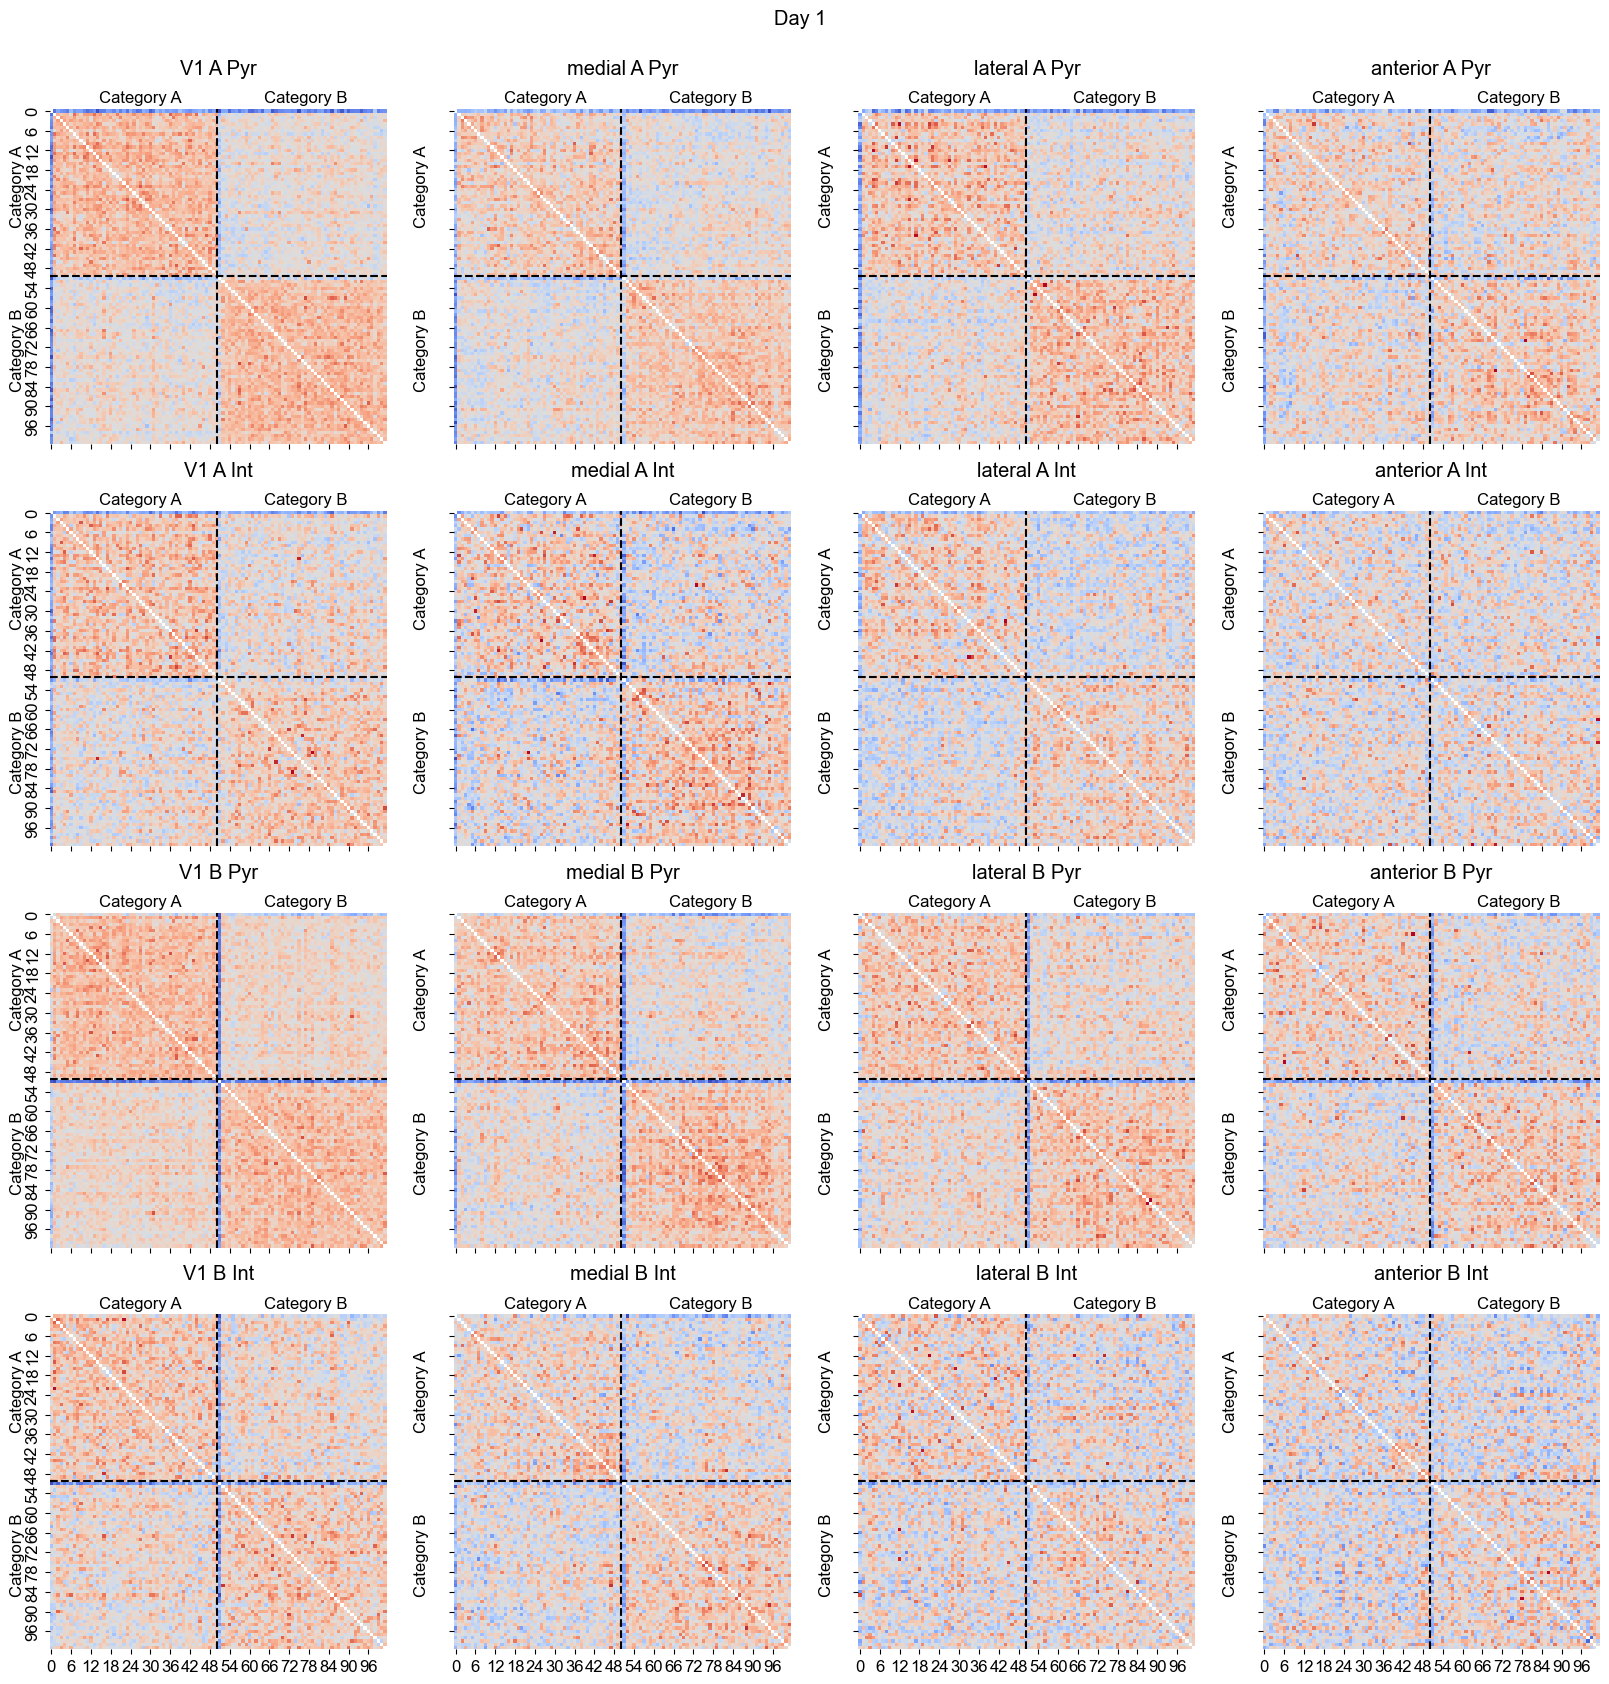

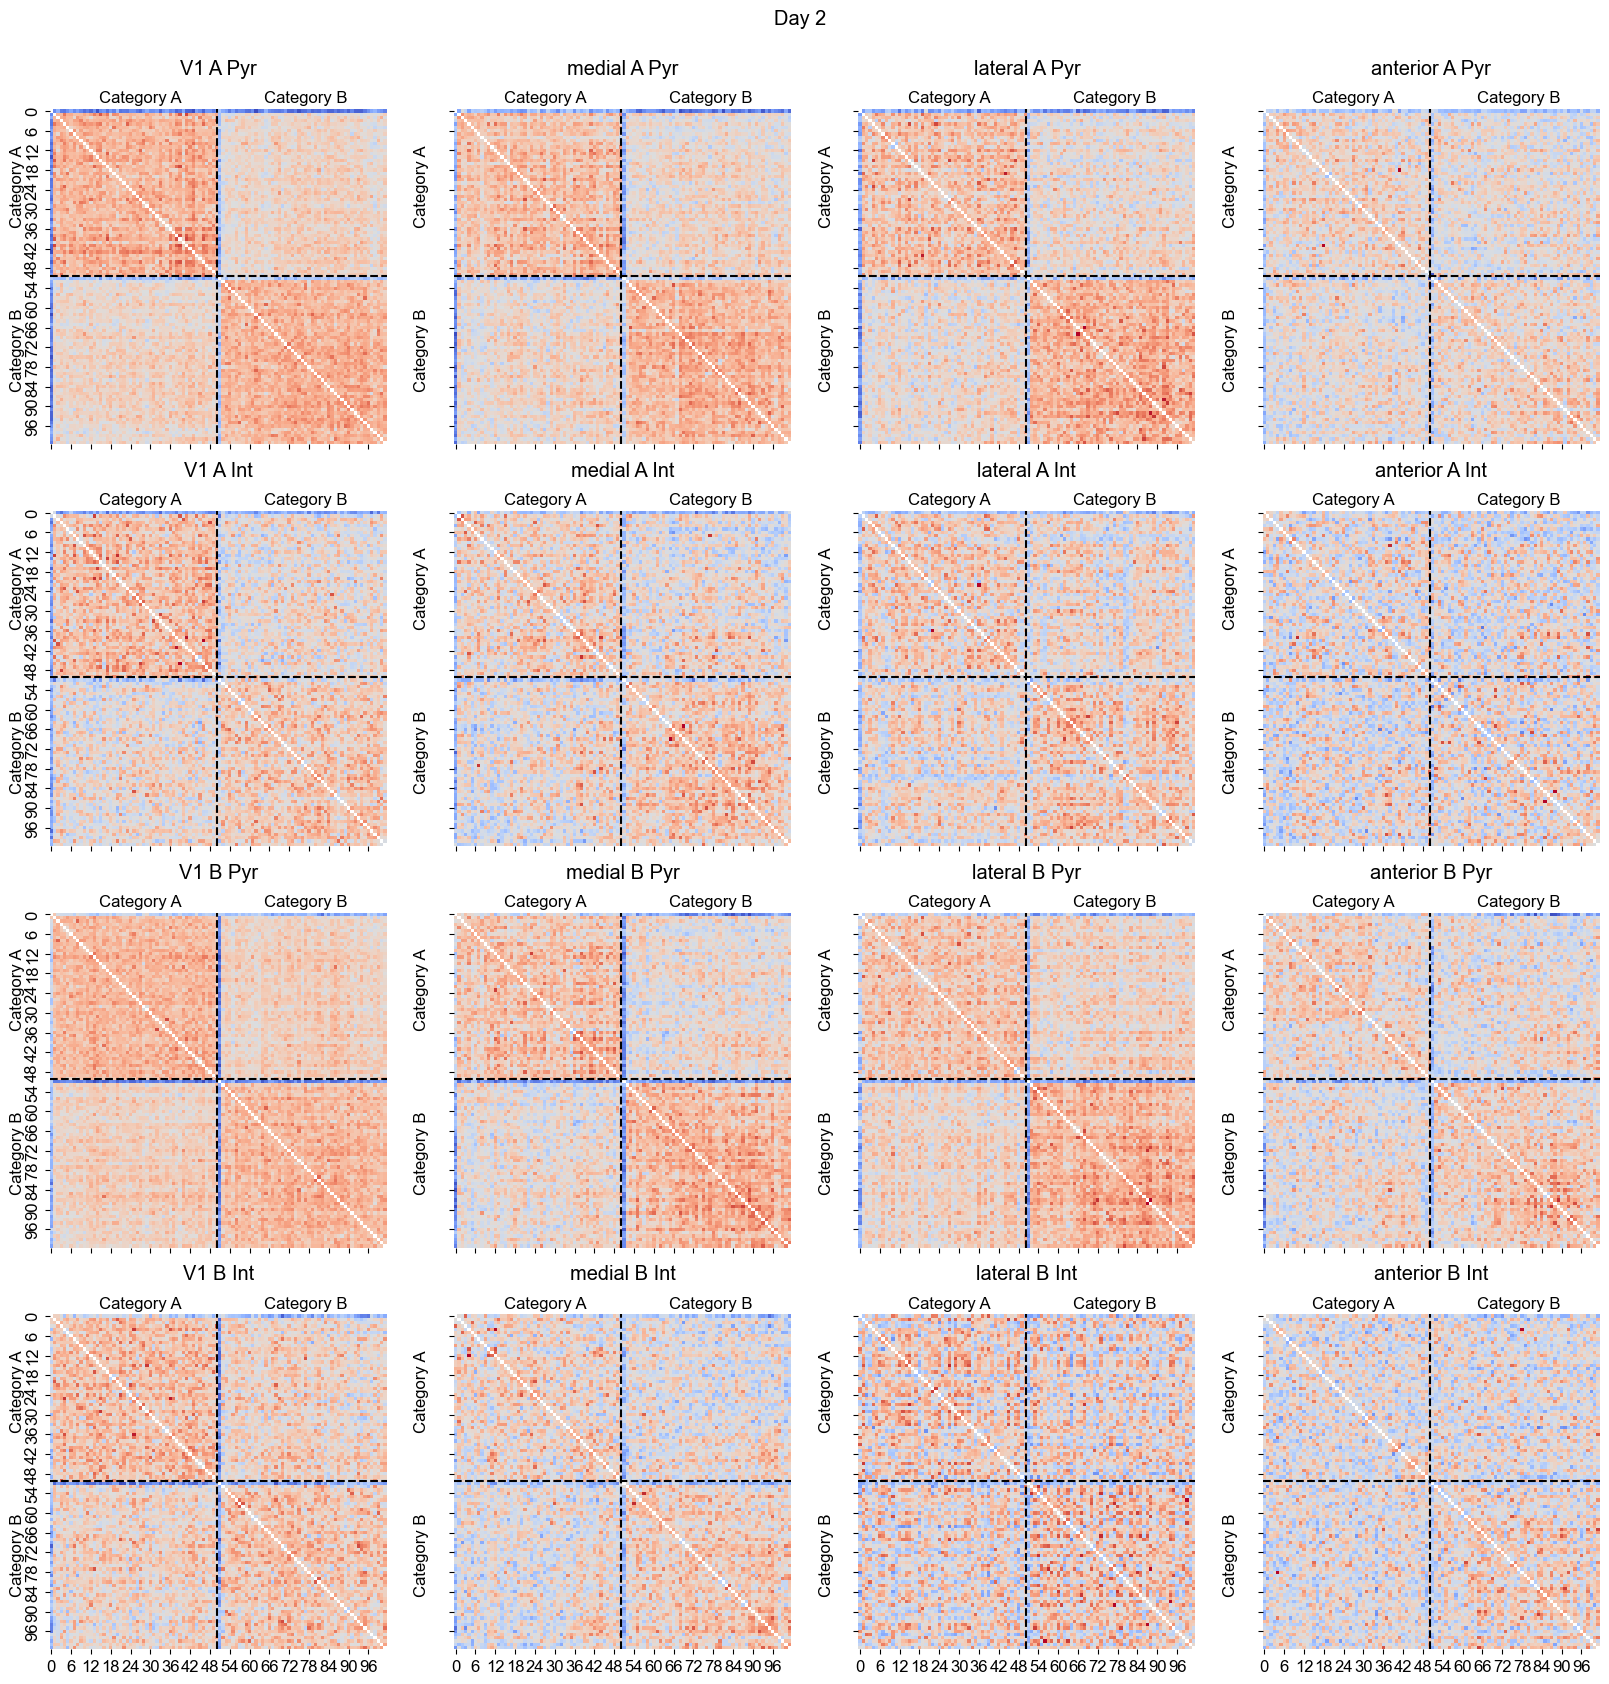

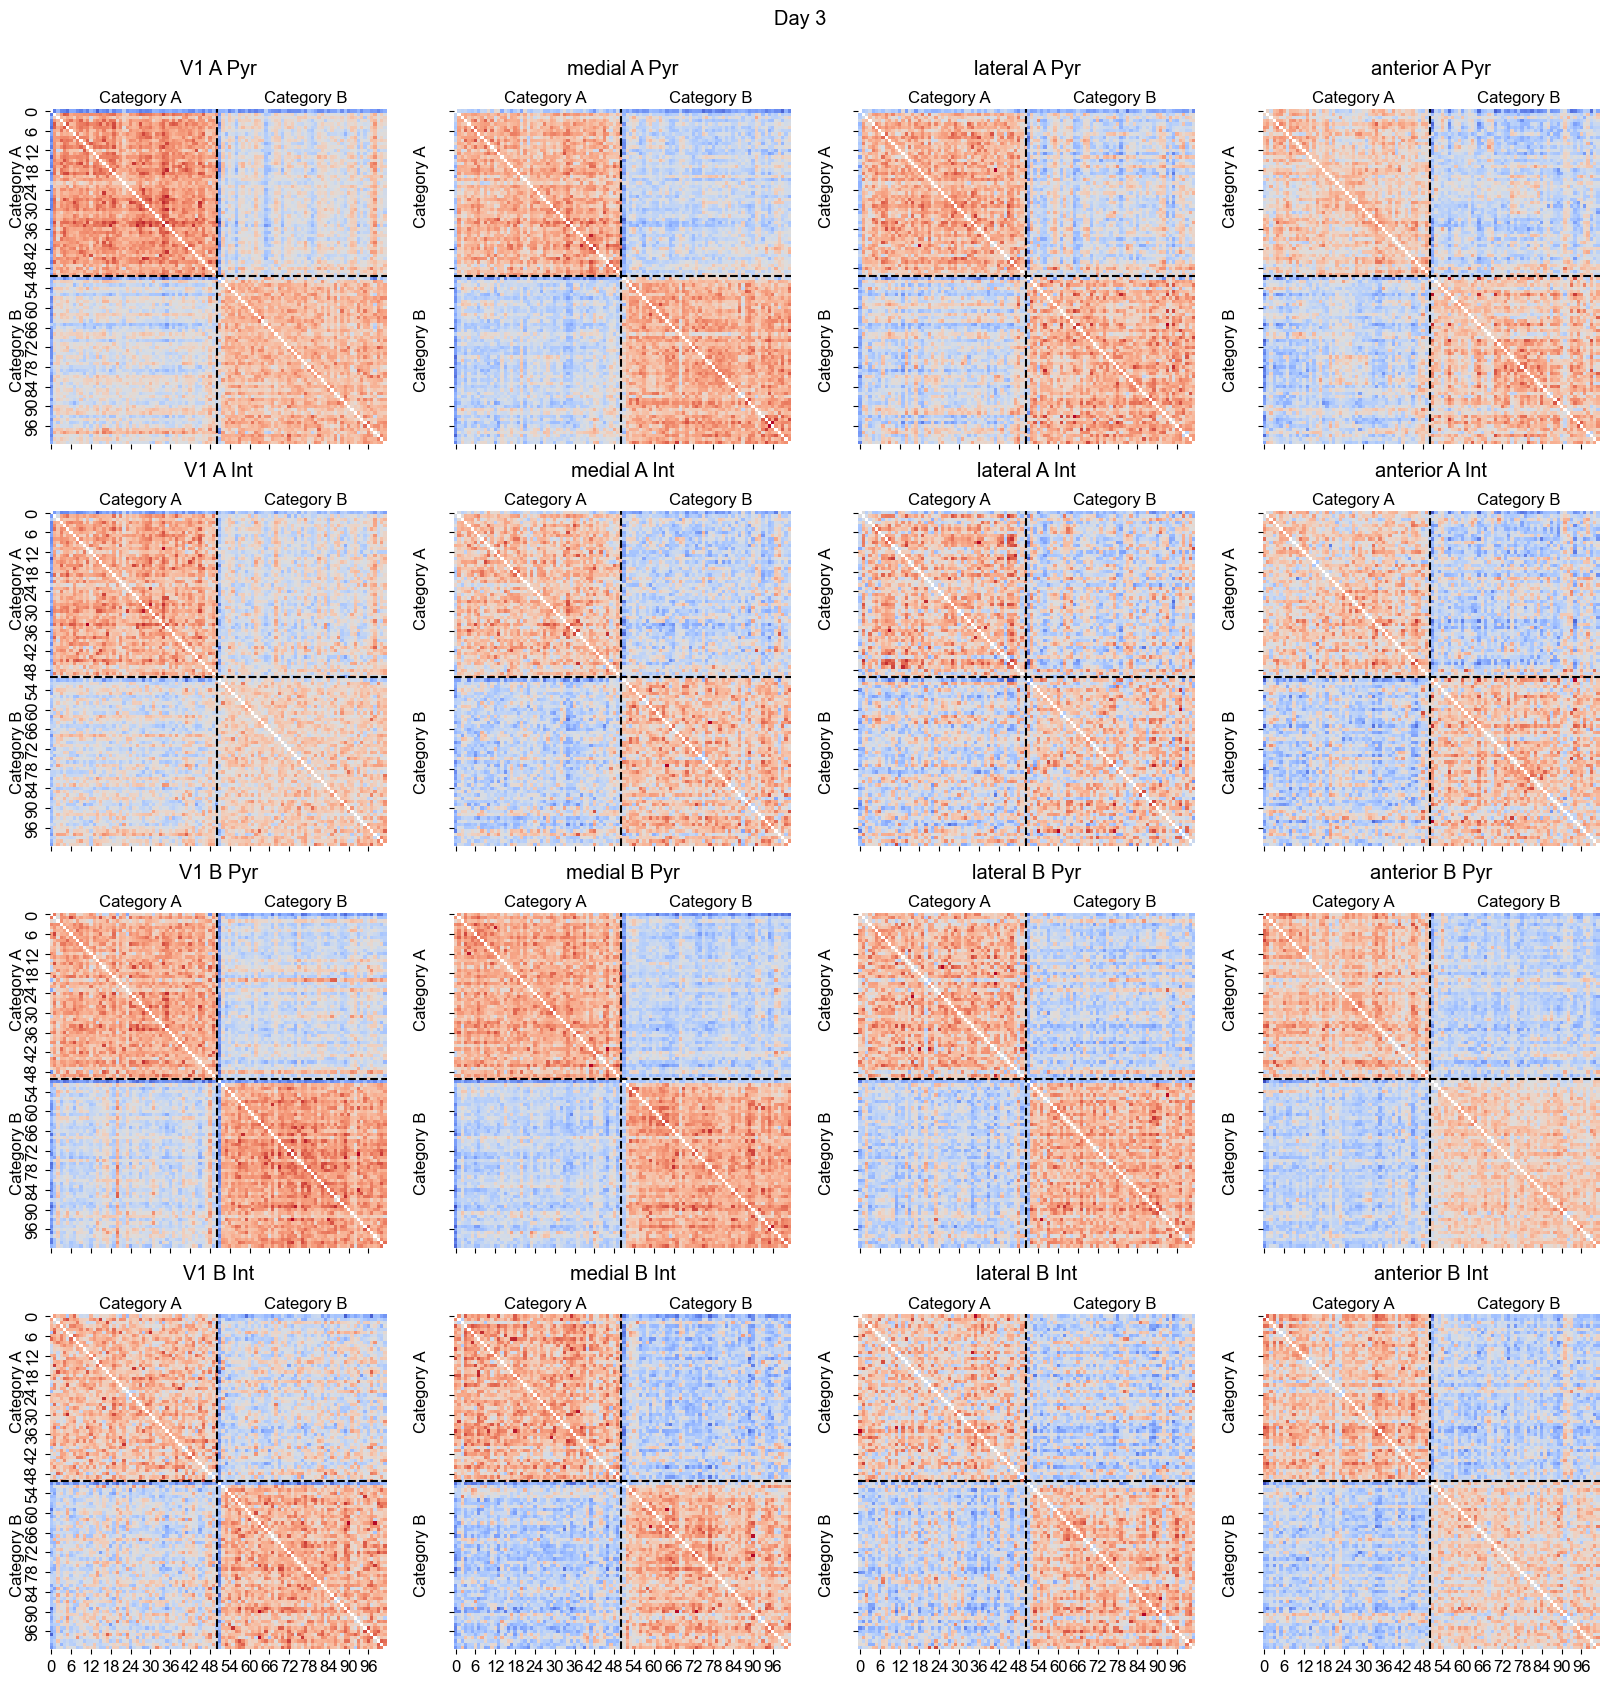

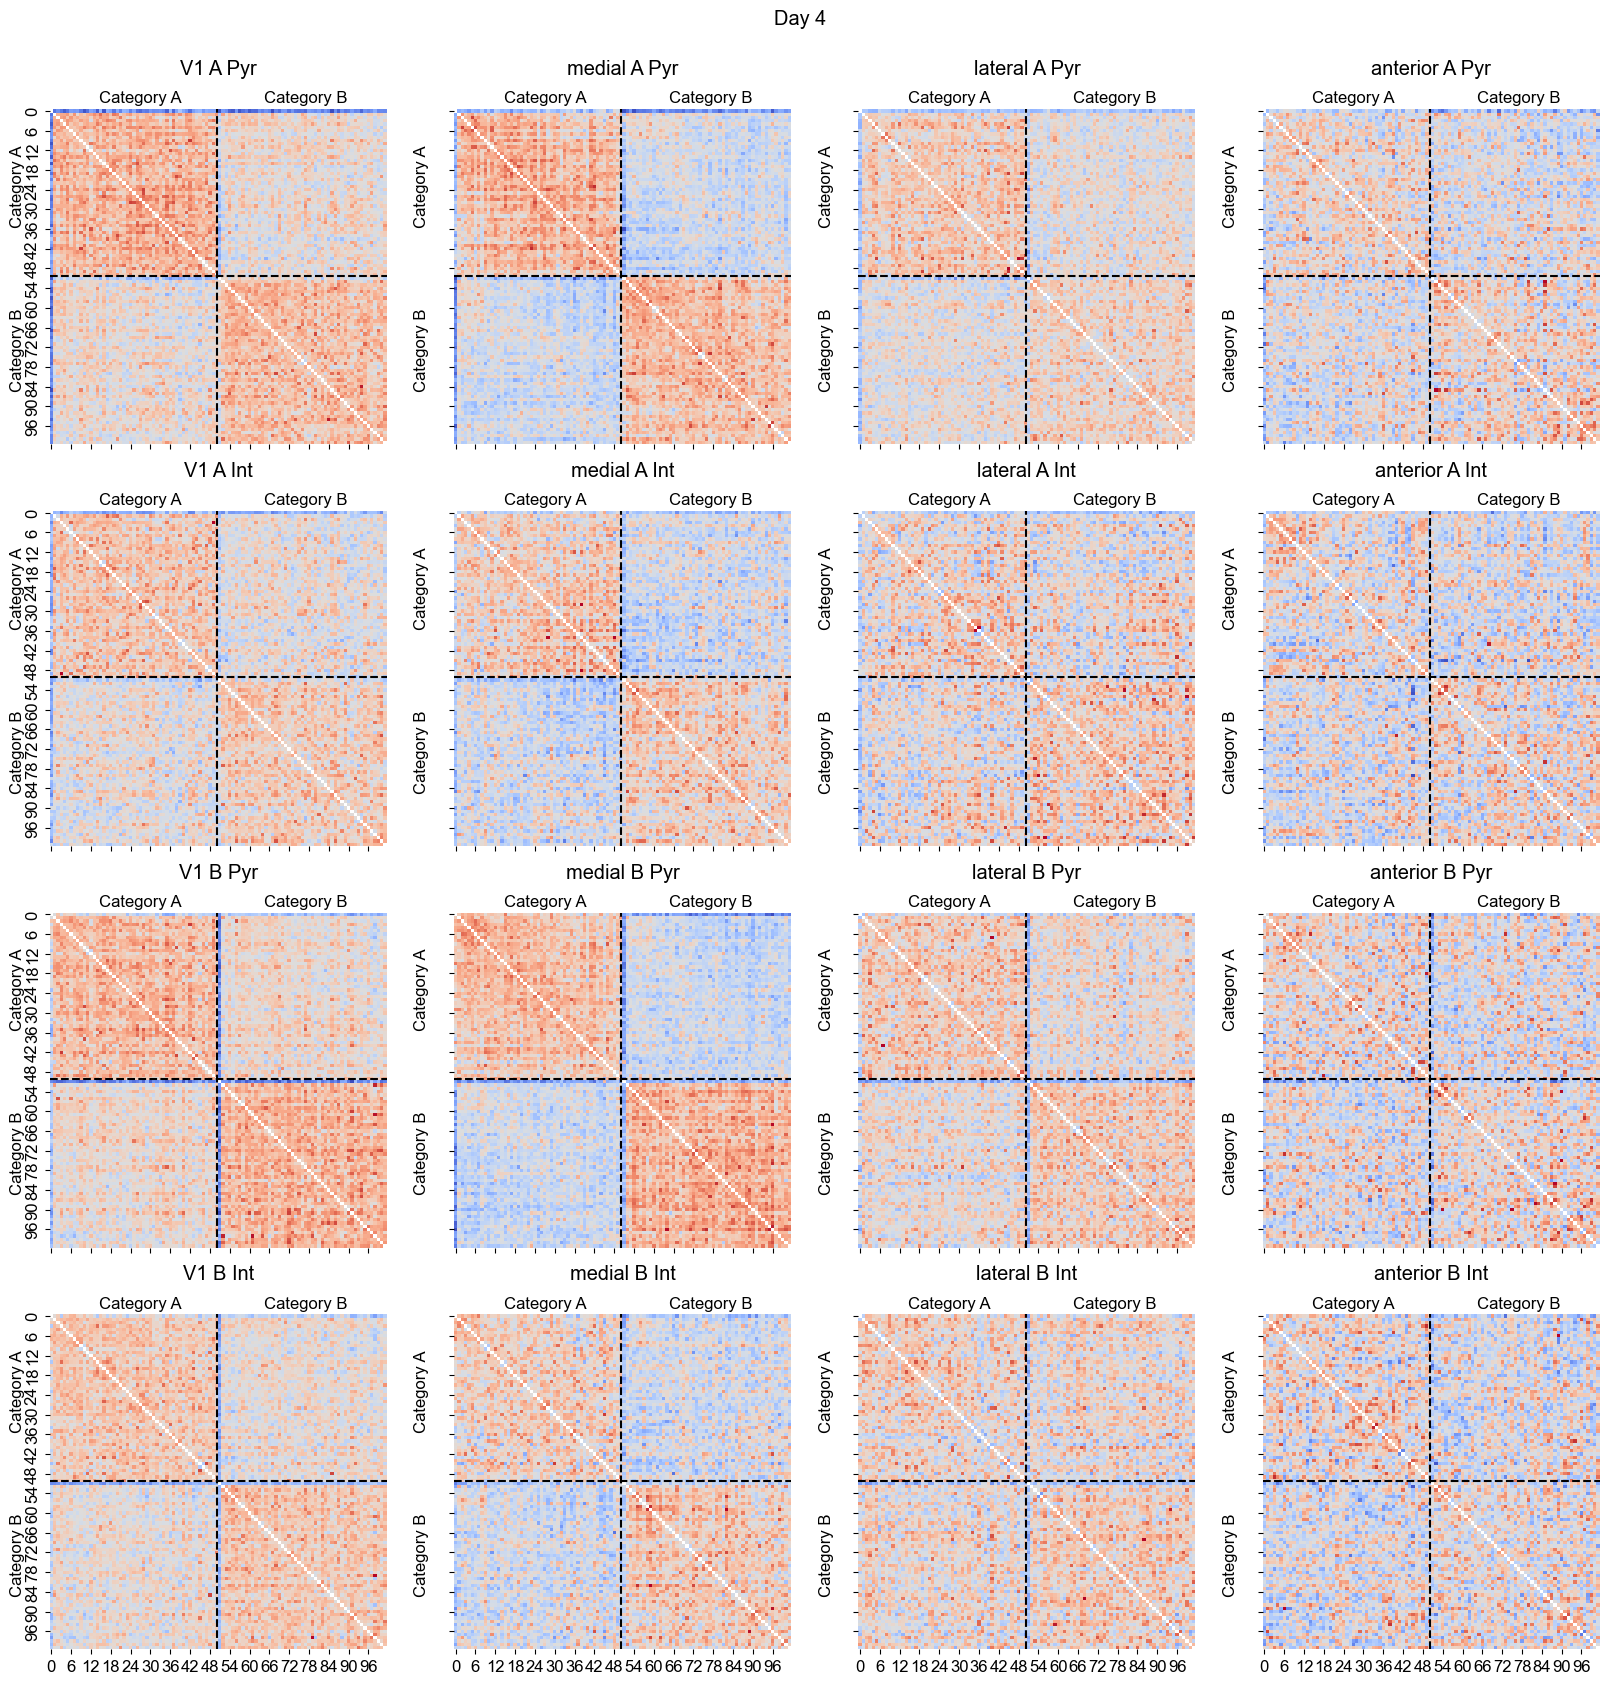

In [6]:
first_day = np.arange(0,16,4)
second_day = np.arange(1,16,4)
third_day = np.arange(2,16,4)
fourth_day = np.arange(3,16,4)
sess_days = [first_day, second_day, third_day, fourth_day]
for iday, day in enumerate(sess_days):
    fig, ax = plt.subplots(4,4, figsize=(20,20), sharex=True, sharey=True)
    for ia, area in enumerate(['V1', 'medial', 'lateral', 'anterior']): 
        i=0
        for ic, category in enumerate(['A', 'B']):
            for icell, celltype in enumerate(['Pyr', 'Int']):
                representation_matrix = np.nanmean(overall_mtx[day,ia,ic,icell,:,:], axis=0)
                plot_sim_matrix(ax[i,ia],representation_matrix)
                ax[i,ia].set_title(f"{area} {category} {celltype}", pad=25, loc='center')
                i+=1
    plt.suptitle(f"Day {iday+1}", y=0.93)

# quick routine to summarize the matrices obtaining their GI

In [9]:
GI_df = pd.DataFrame(columns=['day', 'area', 'category', 'celltype', 'GI', 'intercat'])
first_day = np.arange(0,16,4)
second_day = np.arange(1,16,4)
third_day = np.arange(2,16,4)
fourth_day = np.arange(3,16,4)
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    for ia, area in enumerate(['V1', 'medial', 'lateral', 'anterior']):
        for ic, category in enumerate(['A', 'B']):
            for icell, celltype in enumerate(['Pyr', 'Int']):
                overall_mtx[iss,ia,ic,icell,:,:]
                cat_A = np.nanmean(overall_mtx[iss,ia,ic,icell, 1:51, 1:51]) # intracategory A similarity average without the first instance (the one used to pick the neurons)
                cat_B = np.nanmean(overall_mtx[iss,ia,ic,icell, 52:, 52:]) # intracategory B similarity  average without the first instance (the one used to pick the neurons)
                intercat = np.nanmean(overall_mtx[iss,ia,ic,icell, 1:51, 52:]) # intercategory similarity average without the first instances of each category
                GI = np.mean([cat_A,cat_B]) - intercat
                if iss in first_day:
                    day = 1
                elif iss in second_day:
                    day = 2
                elif iss in third_day:
                    day = 3
                elif iss in fourth_day:
                    day = 4
                df = pd.DataFrame({'mouse': name, 'date': date, 'day':day, 'area': area, 'category': category, 'celltype': celltype, 'GI': GI , 'intercat': intercat}, index=[0])
                GI_df = pd.concat([GI_df, df], ignore_index=True)
GI_df['day'] = GI_df['day'].map({1: 'all rewarded before', 2: 'first day of training', 3: 'last day of training', 4: 'all rewarded after'})

Summarizing the data in this way makes lazy plotting really easy:

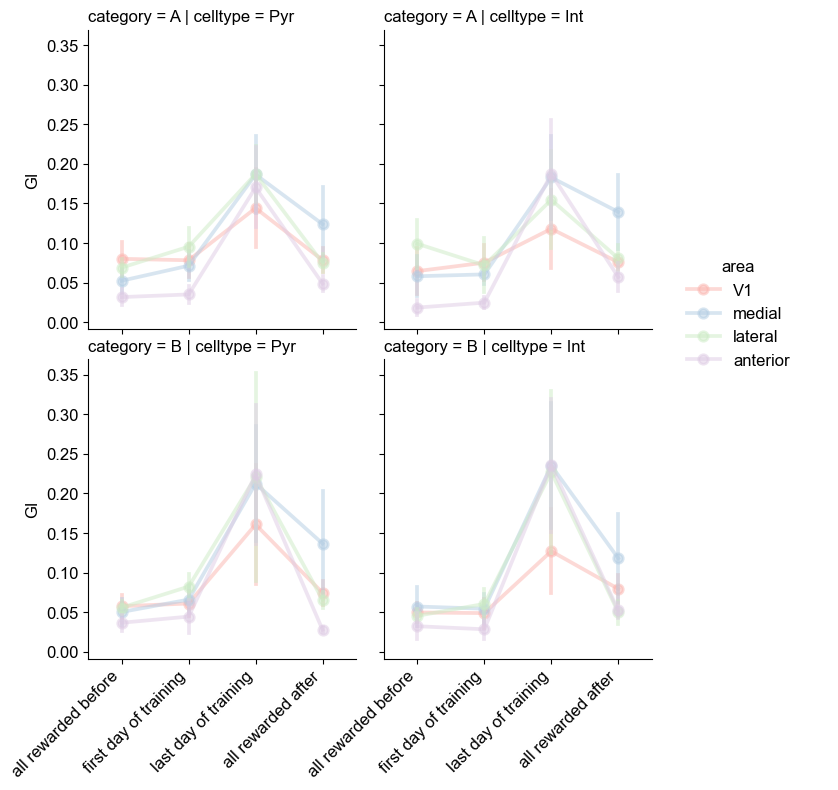

In [29]:
g = sns.catplot(data=GI_df, x='day', y='GI', hue='area', row = 'category', col='celltype', kind='point', errorbar='se', 
                estimator='mean', palette='Pastel1', hue_order=['V1', 'medial', 'lateral', 'anterior'], alpha=0.5)
g.figure.set_figwidth(7)
g.figure.set_figheight(7)
g.set_xticklabels(rotation=45, ha='right')
g.set_xlabels('')
g.legend.set_bbox_to_anchor([1.15, .68])

lets look at the granularity of the data each point is a session:

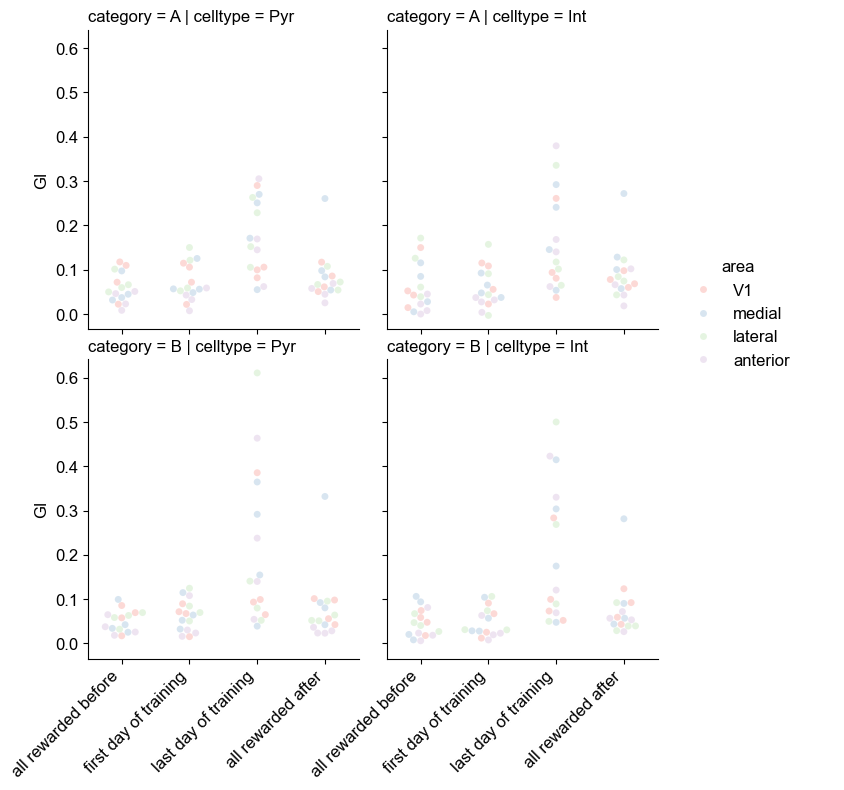

In [28]:
g = sns.catplot(data=GI_df, x='day', y='GI', hue='area', row = 'category', col='celltype', kind='swarm', errorbar='se', 
                estimator='mean', palette='Pastel1', hue_order=['V1', 'medial', 'lateral', 'anterior'], alpha=0.5)
# rotate x-axis labels
g.figure.set_figwidth(7)
g.figure.set_figheight(7)
g.set_xticklabels(rotation=45, ha='right')
g.set_xlabels('')
g.legend.set_bbox_to_anchor([1.15, .68])

Looking to it, it seems like theres one session that is really different from the rest (look at the ),  lets look at it:

In [57]:
GI_df.query("day == 'last day of training'").sort_values(by='GI', ascending=False).head(20)

day      area category celltype        GI  intercat  \
106  last day of training   lateral        B      Pyr  0.610528 -0.272644   
107  last day of training   lateral        B      Int  0.499819 -0.241261   
110  last day of training  anterior        B      Pyr  0.463241 -0.221489   
111  last day of training  anterior        B      Int  0.422762 -0.205165   
103  last day of training    medial        B      Int  0.414562 -0.195845   
98   last day of training        V1        B      Pyr  0.385345 -0.147392   
109  last day of training  anterior        A      Int  0.379425 -0.169288   
102  last day of training    medial        B      Pyr  0.364423 -0.145451   
105  last day of training   lateral        A      Int  0.335381 -0.159263   
239  last day of training  anterior        B      Int  0.330051 -0.152273   
108  last day of training  anterior        A      Pyr  0.305097 -0.123831   
231  last day of training    medial        B      Int  0.303674 -0.113427   
101  last day of training    medial        A      Int  0.291893 -0.126151   
230  last day of training    medial        B      Pyr  0.291482 -0.103522   
96   last day of training        V1        A      Pyr  0.289841 -0.093144   
99   last day of training        V1        B      Int  0.283290 -0.085704   
100  last day of training    medial        A      Pyr  0.269847 -0.112155   
171  last day of training   lateral        B      Int  0.268539 -0.085749   
104  last day of training   lateral        A      Pyr  0.262914 -0.080663   
97   last day of training        V1        A      Int  0.260795 -0.106603   

    mouse        date  
106  VG11  2024_11_14  
107  VG11  2024_11_14  
110  VG11  2024_11_14  
111  VG11  2024_11_14  
103  VG11  2024_11_14  
98   VG11  2024_11_14  
109  VG11  2024_11_14  
102  VG11  2024_11_14  
105  VG11  2024_11_14  
239  VG15  2024_10_31  
108  VG11  2024_11_14  
231  VG15  2024_10_31  
101  VG11  2024_11_14  
230  VG15  2024_10_31  
96   VG11  2024_11_14  
99   VG11  2024_11_14  
100  VG11  2024_11_14  
171  VG14  2024_11_21  
104  VG11  2024_11_14  
97   VG11  2024_11_14

The sessions coming from the second texture pair (week) we tried on VG11 seem higher in GI than the others, especially on the last training day (optimal day)

```python
VG11.append({'mname': 'VG11', 'datexp': '2024_11_04', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_05', 'blk':'3'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_14', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_15', 'blk':'2'})
```

lets see how it looks if we remove those sessions:

In [58]:
GI_wo_lastVG11 = GI_df.copy()
GI_wo_lastVG11['date'] =  pd.to_datetime(GI_wo_lastVG11['date'], format='%Y_%m_%d')
# exclude rows of mouse VG11 between 2024-11-04 and 2024-11-15
query = "mouse == 'VG11' & date >= '2024-11-04' & date <= '2024-11-15'"
GI_wo_lastVG11 = GI_wo_lastVG11.query(f"not ({query})")
GI_wo_lastVG11

day      area category celltype        GI  intercat  \
0    all rewarded before        V1        A      Pyr  0.071653  0.017632   
1    all rewarded before        V1        A      Int  0.042662  0.032249   
2    all rewarded before        V1        B      Pyr  0.057864  0.023106   
3    all rewarded before        V1        B      Int  0.047848  0.004931   
4    all rewarded before    medial        A      Pyr  0.037066  0.005561   
..                   ...       ...      ...      ...       ...       ...   
251   all rewarded after   lateral        B      Int  0.039650  0.054237   
252   all rewarded after  anterior        A      Pyr  0.044454 -0.002672   
253   all rewarded after  anterior        A      Int  0.101848 -0.035852   
254   all rewarded after  anterior        B      Pyr  0.023594  0.010635   
255   all rewarded after  anterior        B      Int  0.053371 -0.019831   

    mouse       date  
0    VG11 2024-10-15  
1    VG11 2024-10-15  
2    VG11 2024-10-15  
3    VG11 2024-10-15  
4    VG11 2024-10-15  
..    ...        ...  
251  VG15 2024-11-01  
252  VG15 2024-11-01  
253  VG15 2024-11-01  
254  VG15 2024-11-01  
255  VG15 2024-11-01  

[192 rows x 8 columns]

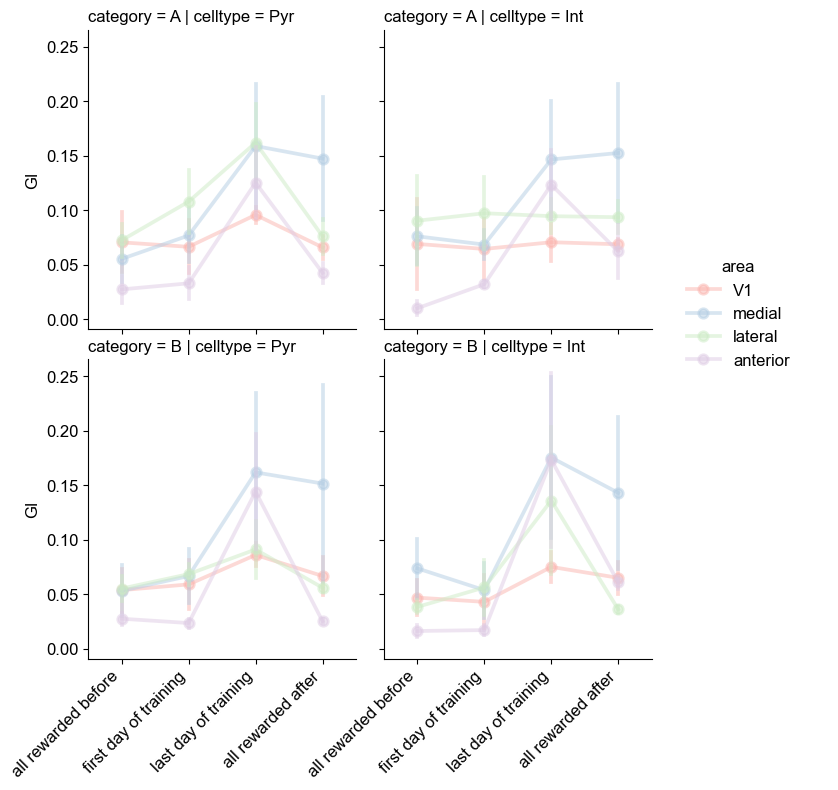

In [59]:
g = sns.catplot(data=GI_wo_lastVG11, x='day', y='GI', hue='area', row = 'category', col='celltype', kind='point', errorbar='se', 
                estimator='mean', palette='Pastel1', hue_order=['V1', 'medial', 'lateral', 'anterior'], alpha=0.5)
g.figure.set_figwidth(7)
g.figure.set_figheight(7)
g.set_xticklabels(rotation=45, ha='right')
g.set_xlabels('')
g.legend.set_bbox_to_anchor([1.15, .68])

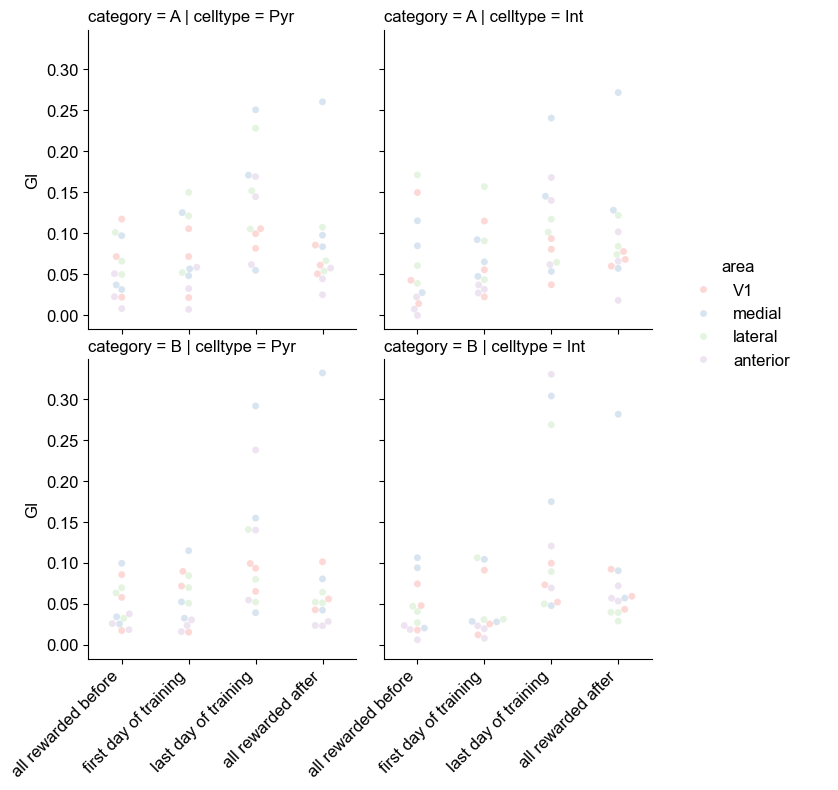

In [61]:
g = sns.catplot(data=GI_wo_lastVG11, x='day', y='GI', hue='area', row = 'category', col='celltype', kind='swarm',
                estimator='mean', palette='Pastel1', hue_order=['V1', 'medial', 'lateral', 'anterior'], alpha=0.5)
g.figure.set_figwidth(7)
g.figure.set_figheight(7)
g.set_xticklabels(rotation=45, ha='right')
g.set_xlabels('')
g.legend.set_bbox_to_anchor([1.15, .68])